# Extreme Multi-label Machine Model

This Jupyter Notebook goes over various methods of multi-label processing using heathcare data

In [1]:
# Create environemnt if necessary
# conda create -n new environment --file req.txt
conda install --file req.txt
conda env update --file req.txt
pip install -r req.txt
pip install -U -r req.txt 
conda create --name XML_LABEL --file req.txt

In [2]:
# load data
from zipfile import ZipFile
file_name = "data/data.zip"
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # printing all the contents of the zip file
    zip.printdir()
 
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall(path='data')
    print('Done!')

File Name                                             Modified             Size
embedded_y_graph.txt                           2018-08-28 23:40:48      9803371
labels_list.hkl                                2018-09-04 12:02:24        75184
X_test.hkl                                     2018-09-04 12:02:24     76046143
X_train.hkl                                    2018-09-04 12:02:24    154382149
y_test.hkl                                     2018-09-04 12:02:30   1139166144
y_train.hkl                                    2018-09-04 12:02:42   2312846144
Extracting all the files now...
Done!


### Baseline Machine Gaussian Naive Bayes Learning Model

In [ ]:
import hickle as hkl
X_train = hkl.load( 'data/X_train.hkl' )
X_test = hkl.load( 'data/X_test.hkl' )
y_test = hkl.load( 'data/y_test.hkl' )
y_train = hkl.load( 'data/y_train.hkl' )

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.naive_bayes import GaussianNB

classif_list = []
train_score_list, test_score_list = [], []

# Training
print("Training")
for i in range(len(labels_list)):
    y_train_for_this_ub04 = y_train[:,i]
    new_classifier = GaussianNB()
    new_classifier.fit(X_train, y_train_for_this_ub04)
    classif_list.append(new_classifier)

# Test & display results
print("Test and display results")
for i in range(len(labels_list)):
    classif = classif_list[i]
    train_score = float('{0:.3f}'.format(classif.score(X_train, y_train[:,i])))
    test_score = float('{0:.3f}'.format(classif.score(X_test, y_test[:,i])))
    train_score_list.append(train_score)
    test_score_list.append(test_score)
    print('Detecting {} with {}% accuracy (training {}%)'.format(labels_list[i], 100*test_score, 100*train_score))

predict_train = np.zeros_like(y_train)
predict_test = np.zeros_like(y_test)
for i in range(len(labels_list)):
    classif = classif_list[i]
    predict_train[:,i] = classif.predict(X_train)
    predict_test[:,i] = classif.predict(X_test)
acc_train = 1 - np.sum(np.abs(predict_train - y_train))/(y_train.shape[0]*y_train.shape[1])
acc_test = 1 - np.sum(np.abs(predict_test - y_test))/(y_test.shape[0]*y_test.shape[1])
print('###')
print('Global accuracy: testing {}, training {}'.format(acc_test, acc_train))

well_labeled = 0
for i in range(len(y_train)):
    if np.sum(np.abs(y_train[i,:] - predict_train[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} training samples were well labeled'.format(well_labeled,len(y_train)))

well_labeled = 0
for i in range(len(y_test)):
    if np.sum(np.abs(y_test[i,:] - predict_test[i,:])) == 0:
        well_labeled +=1
print('Overall {} out of the {} testing samples were well labeled'.format(well_labeled,len(y_test)))

# Evidemment, en plus d'être mathématiquement désapprouvée, cette méthode est encombrante:
# imaginez avoir à construire un million de classificateurs ! Ce n'est pas du tout extensible à de la classification extrême

### Deep Extreme Multi-label Learning by Zhang et al
Follwing XML methods in the paper [Deep Extreme Multi-label Learning by Zhang et al](https://arxiv.org/pdf/1704.03718.pdf) and [eXtreme Multilabel Classification Notebook](https://github.com/therhappy/xml-tuto/blob/master/eXtreme%20Multilabel%20Classification%20Notebook%20-%20EN.ipynb). 

![Machine Learning Path Image](https://github.com/Smone5/XML_EHR_LABELS/blob/master/images/labelmatrix.png "Machine Learning Path")

The goal in this section is build an embedded vector of the UB-04, ICD-10, CPT and Modifier labels. This embedded vector will be used to predict the correct label for EHR procedures.


#### Build Labels Embedded Graph
1. Load data
2. Build edges list
3. Convert Label Edges to Embedded Vectors
4. Convert Features to Embedded Vectors

##### 1. Load data

In [6]:
import numpy as np
import hickle as hkl

In [106]:
y_train = hkl.load( 'data/y_train.hkl' )
y_test = hkl.load( 'data/y_test.hkl' )
labels_list = hkl.load('data/labels_list.hkl' )

In [109]:
# view imported lables
labels_list[0:5]

['10022', '10060', '10120', '10160', '10180']

In [10]:
print("Count of label names: ", len(labels_list))

Count of label names:  8630


In [11]:
# view imported trianing labels
y_train[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [12]:
# view imported trianing labels
y_test[0:5]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [13]:
#y_train = y_train[0:1000]
print("Labels training rows", y_train.shape[0])
print("Labels training columns", y_train.shape[1])

Labels training rows 67000
Labels training columns 8630


In [14]:
#y_test = y_test[0:1000]
print("Labels training rows", y_test.shape[0])
print("Labels training columns", y_test.shape[1])

Labels training rows 33000
Labels training columns 8630


Note:
The label columns and training columns must be the same size to continue.

##### 2. Build edges list

In [70]:
train_edges = [] # blank list to hold edges
test_edges = [] # blank list to hold edges


In [71]:
%%time
# build training edges
for row in y_train:
    act = list(np.where(row == 1))
    act = [list(i) for i in act ][0]
    for i in range(len(act)):
        for j in range(len(act)):
            #matrix[i,act[j]] +=1
            if i < j:
                train_edges.append([act[i],act[j]])
        

CPU times: user 5.19 s, sys: 2.06 s, total: 7.24 s
Wall time: 8.22 s


In [72]:
%%time
# build test edges
for row in y_test:
    act = list(np.where(row == 1))
    act = [list(i) for i in act ][0]
    for i in range(len(act)):
        for j in range(len(act)):
            #matrix[i,act[j]] +=1
            if i < j:
                test_edges.append([act[i],act[j]])

CPU times: user 3.22 s, sys: 1.14 s, total: 4.36 s
Wall time: 5.04 s


In [73]:
# Remove duplicate edges from train list
train_edges2 = [[x,y] for x,y in (set(tuple(x) for x in train_edges))]

In [74]:
# Remove duplicate edges from test list
test_edges2 = [[x,y] for x,y in (set(tuple(x) for x in test_edges))]

In [75]:
#View first 5 rows of training edges
train_edges2[:5]

[[292, 8167], [2538, 2974], [959, 3912], [1559, 1957], [3897, 4036]]

In [76]:
#View first 5 rows of test edges
test_edges2[:5]

[[2920, 4622], [292, 8167], [1559, 1957], [2538, 2974], [6208, 6330]]

In [22]:
'''
# code for converting the numerical number back to original label for checking.
label_dict = {}
for i in range(len(labels_list)):
    label_dict[i] = labels_list[i]

for i in range(len(edges2)):
    val1 = edges2[i][0]
    val2 = edges2[i][1]
    edges2[i][0] = label_dict[val1]
    edges2[i][1] = label_dict[val2]
'''

'\n# code for converting the numerical number back to original label for checking.\nlabel_dict = {}\nfor i in range(len(labels_list)):\n    label_dict[i] = labels_list[i]\n\nfor i in range(len(edges2)):\n    val1 = edges2[i][0]\n    val2 = edges2[i][1]\n    edges2[i][0] = label_dict[val1]\n    edges2[i][1] = label_dict[val2]\n'

In [24]:
# convert train edges to edge list file for Deepwalk

import networkx as nx
G=nx.Graph()
for edge in train_edges2:
        G.add_edge(edge[0], edge[1])
        
# save as edge list file
with open('deepwalk/graphs/train.edgelist', 'w') as f:
    for edge in G.edges():
        f.write("{} {}\n".format(edge[0] ,edge[1]))

In [25]:
# convert test edges to edge list file for Deepwalk

import networkx as nx
G=nx.Graph()
for edge in test_edges2:
        G.add_edge(edge[0], edge[1])
        
# save as edge list file
with open('deepwalk/graphs/test.edgelist', 'w') as f:
    for edge in G.edges():
        f.write("{} {}\n".format(edge[0] ,edge[1]))

##### Analyze the graph in GraphCrunch 2 or Gephi
At this point you could visulize the graph in GraphCrunch 2 or Gephi
+ [GraphCrunch 2](http://www0.cs.ucl.ac.uk/staff/natasa/graphcrunch2/index.html)
+ [Paper](https://bmcbioinformatics.biomedcentral.com/articles/10.1186/1471-2105-12-24)

##### 3. Convert Label Edges to Embedded Vectors
There are a few methods to convert a network graph each node into a network as a low-dimensional feature vector.

1. [Deepwalk](https://github.com/phanein/deepwalk)
2. [Node2Vec](https://snap.stanford.edu/node2vec/)
3. [Struct2Vec](https://github.com/leoribeiro/struc2vec)
4. Graphlets

Due a paper from Shawn Gu and Tijana Milenković called [*Graphlets versus node2vec and struc2vec in the task of network alignment*](https://www.groundai.com/project/graphlets-versus-node2vec-and-struc2vec-in-the-task-of-network-alignment/), in certain situations a graphlet could outperform Node2Vec or Struct2Vec to quantify node similarities.

However due to time constraints, Deepwalk will be used in this method

*Note* :To use Deepwalk, you must use a Python 2.7 environment at the time of writing this

###### Deepwalk
To run Deepwalk you must run these line while in the folder *deepwalk*. This process can take a while.

deepwalk --input graphs/train.edgelist --number-walks 80 --representation-size 300 --window-size 10
--workers 2 --output graphs/train.embeddings

deepwalk --input graphs/test.edgelist --number-walks 80 --representation-size 300 --window-size 10
--workers 2 --output graphs/test.embeddings

##### 4. Convert Features to Embedded Vectors

In [26]:
# load embeddings
import gensim
train_embedding =gensim.models.KeyedVectors.load_word2vec_format('deepwalk/graphs/train.embeddings')
test_embedding = gensim.models.KeyedVectors.load_word2vec_format('deepwalk/graphs/test.embeddings')

In [27]:
# load vectors from embeddings
V_train = train_embedding[train_embedding.vocab]
V_test = test_embedding[test_embedding.vocab]

/Users/amelton/anaconda/envs/XML_EHR_LABELS/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if sys.path[0] == '':


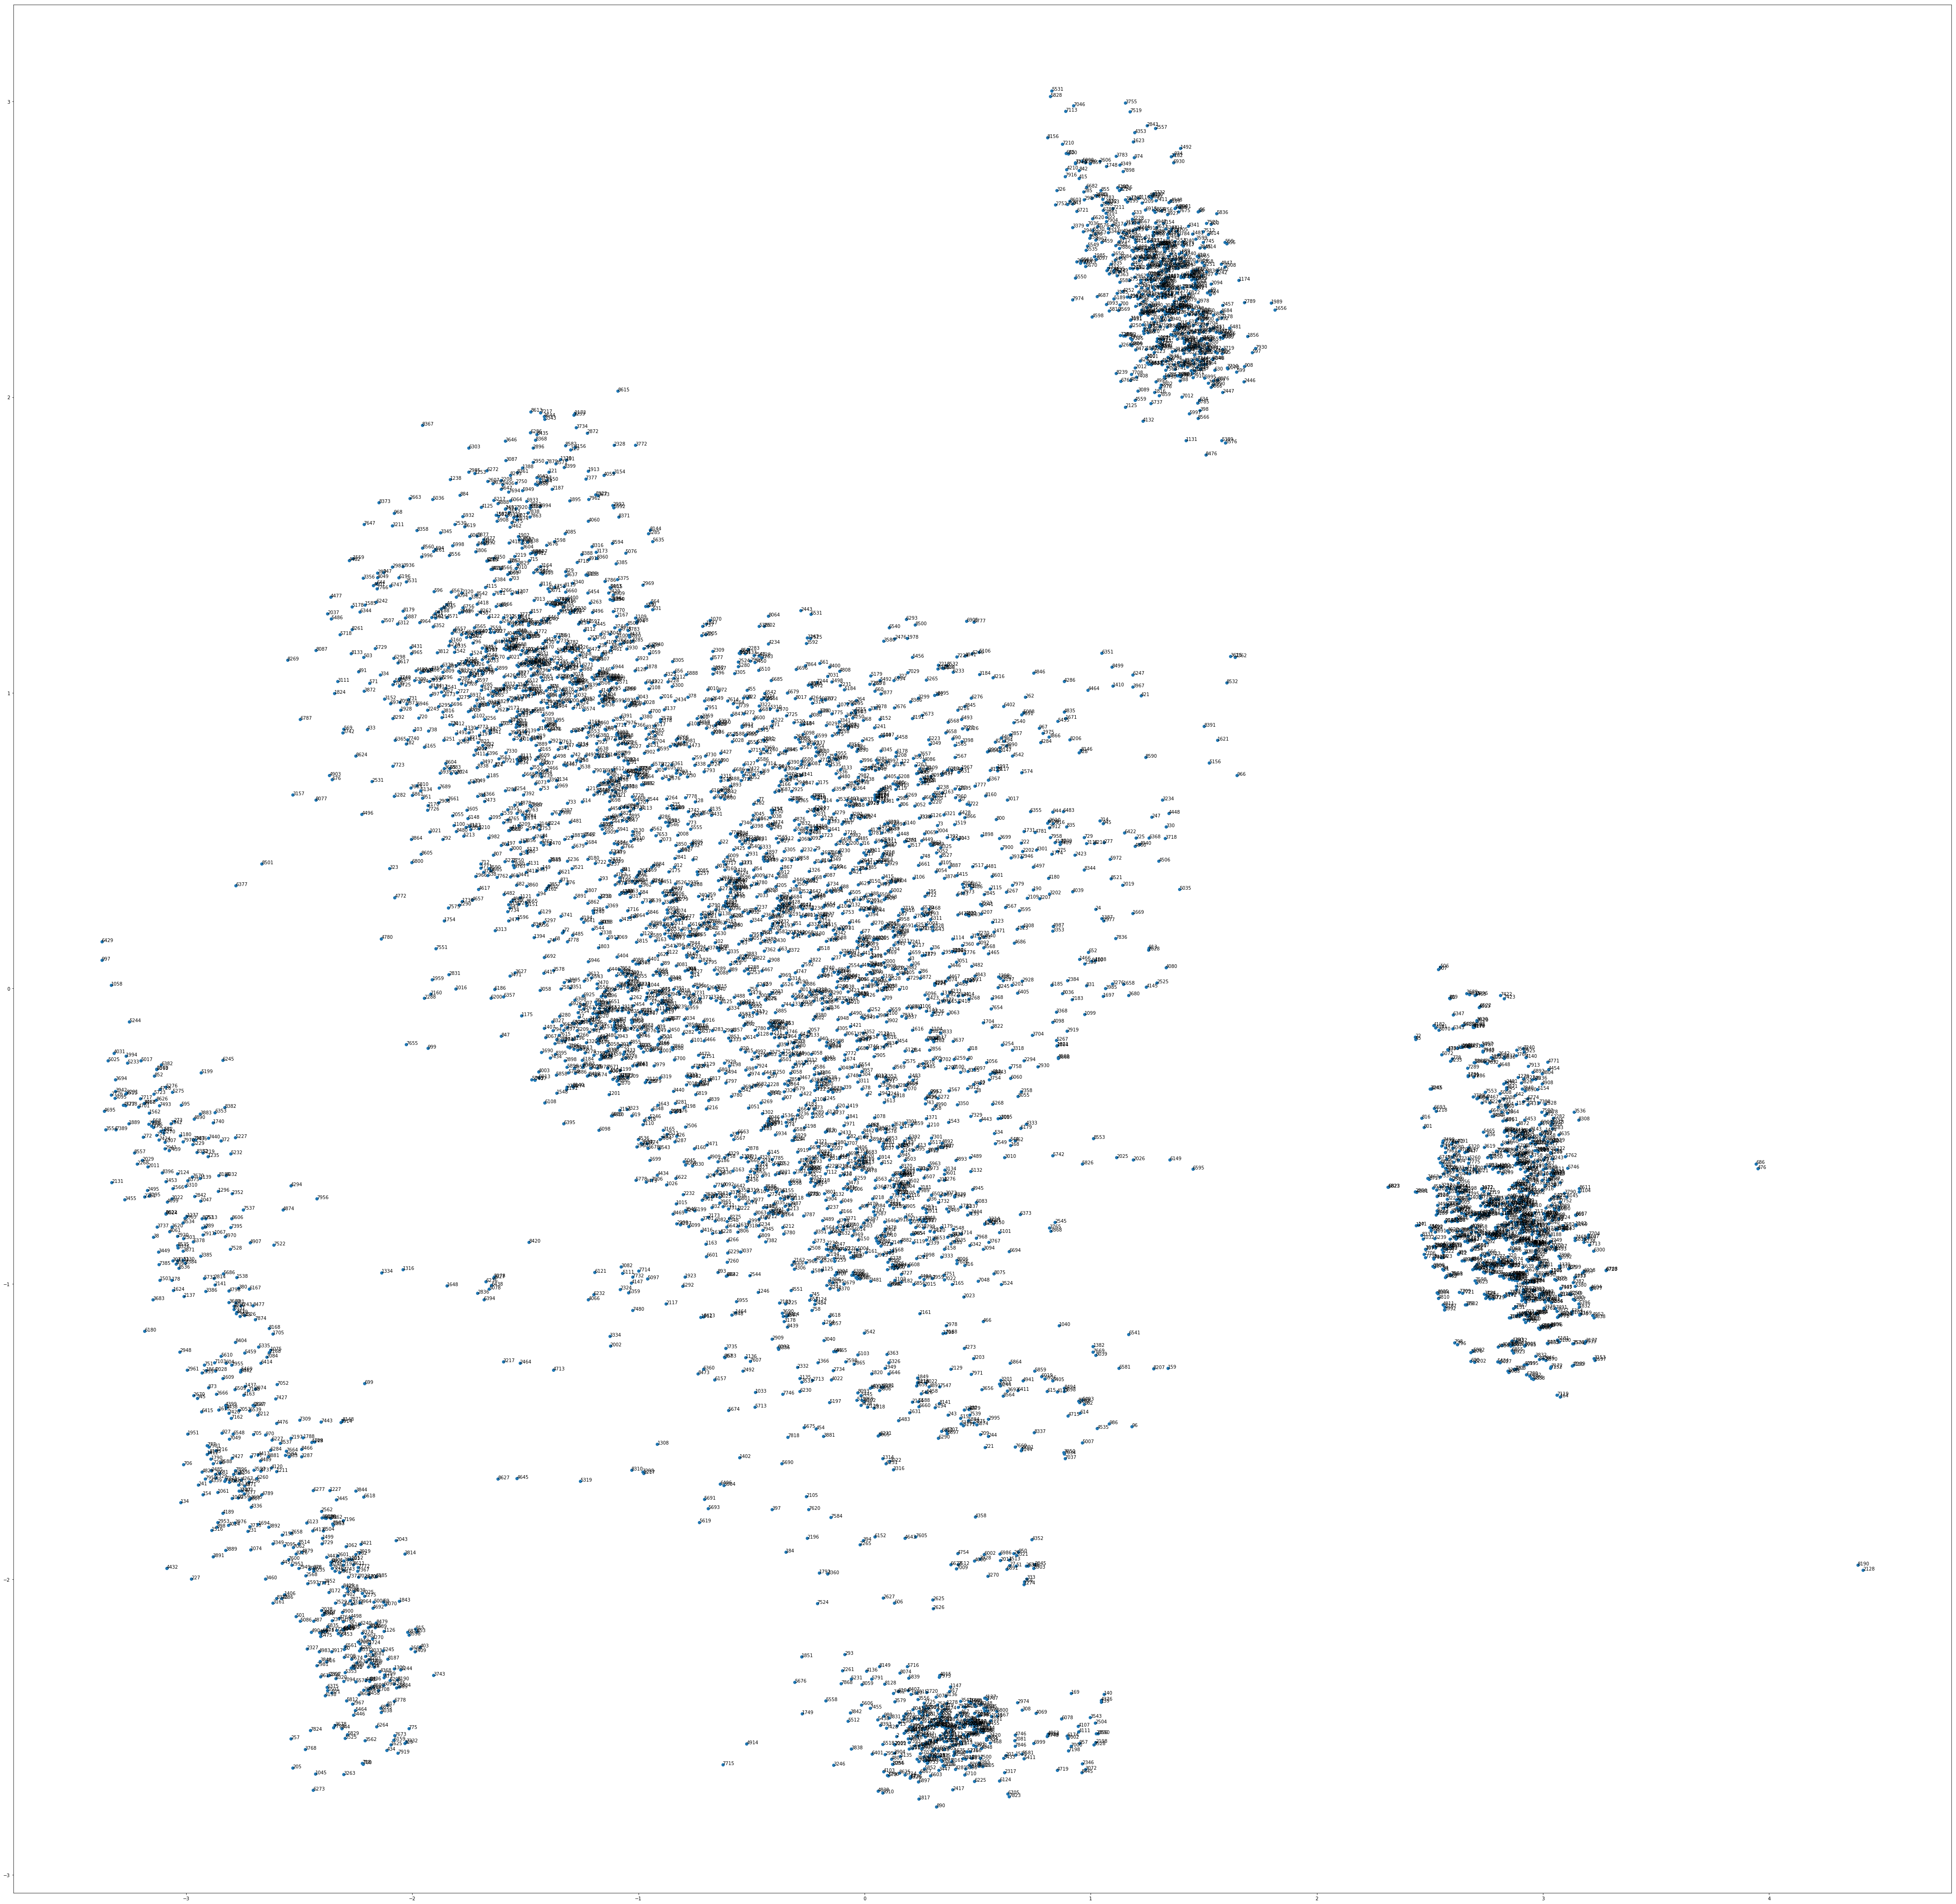

In [30]:
# Plot training embedded vectors into one dimensional graph

from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
%matplotlib inline

pca = PCA(n_components=2)
result = pca.fit_transform(V_train)
# create a scatter plot of the projection
plt.figure(figsize=(75,75))
plt.scatter(result[:, 0], result[:, 1])
words = list(train_embedding.wv.vocab)
for i, word in enumerate(words):
	plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.savefig("images/PCA_graph.png")
plt.show()

Now we need to project the original label matrix to a new matrix including the embedded vectors.

In [31]:
print("Rows: ", V_train.shape[0])
print("Columns: ",V_train.shape[1])

Rows:  6088
Columns:  300


In [32]:
print("Rows: ", y_train.shape[0])
print("Columns: ",y_train.shape[1])

Rows:  67000
Columns:  8630


The embedded vector is 6,088 rows and 300 columns. Each row represents a node and its associated vectors. The orginal label matrix is 67,000 rows and 8,630 columns. Each rows represents a 1 if a label should exists or 0 if one doesn't.

In [119]:
# convert nodes index value to list
node_index = train_embedding.index2word

In [261]:
label_dict = {}
for i in range(len(labels_list)):
    label_dict[i] = labels_list[i]

In [262]:
# create two lists 1) index list 2)labels list
# nodes_list comes from edges used to train
# labels list are the actual labels of the nodes
nodes_list = []
labels_l = []
for i in range(len(train_edges2)):
    val1 = train_edges2[i][0]
    val2 = train_edges2[i][1]
    nodes_list.append(val1)
    nodes_list.append(val2)
    labels_l.append(label_dict[val1]) 
    labels_l.append(label_dict[val2]) 

In [265]:
# combine both lists to create a dicitonary that maps a node index value to its actual label
label_to_node = {}
for i in range(len(labels_l)):
    label_to_node[labels_l[i]] = nodes_list[i]

In [266]:
label_to_node['10160']

3

In [268]:
# sometimes there is node missing in the label_to_node
# maybe a node had no edges, to keep the labels consistent..
# this loop adds back a node if it had no edge
for i in range(len(labels_list)):
    try:
        sorted_x[labels_list[i]]
    except KeyError:
        sorted_x[labels_list[i]] = i

In [269]:
# this orders the dictionary in ascending order by node index value
from operator import itemgetter
from collections import OrderedDict

sorted_x = OrderedDict(sorted(label_to_node.items(), key=itemgetter(1)))

In [271]:
sorted_x['10022']

0

In [275]:
len(sorted_x)

8017

In [274]:
len(V_train)

6088

In [260]:
import pandas as pd
labels_df = pd.DataFrame(data=y_train)
labels_df.head()

,0,1,2,3,4,5,6,7,8,9,...,8620,8621,8622,8623,8624,8625,8626,8627,8628,8629
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [242]:
labels_df['11101'].value_counts()

0    67000
Name: 11101, dtype: int64

In [77]:
train_edges2[0:5]

[[292, 8167], [2538, 2974], [959, 3912], [1559, 1957], [3897, 4036]]

In [ ]:
V_train

In [ ]:
X_train = hkl.load( 'data/X_train.hkl' )
X_test = hkl.load( 'data/X_test.hkl' )

y_train = hkl.load( 'data/y_train.hkl' )
y_test = hkl.load( 'data/y_test.hkl' )

In [ ]:
print("X_train Rows:", X_train.shape[0])
print("X_train Columns:", X_train.shape[1])

In [ ]:
print("y_train Rows:", y_train.shape[0])
print("y_train Columns:", y_train.shape[1])

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
# Project label matrix y_train t 

In [ ]:
norm_matrix[0].shape[0]

In [ ]:
def compile_model(model, k):
    
    from keras.optimizers import RMSprop, SGD
    import tensorflow as tf
    from keras import backend as K

    def auc(y_true, y_pred):
        auc = tf.metrics.auc(y_true, y_pred)[1]
        K.get_session().run(tf.local_variables_initializer())
        return auc  
    
    def as_keras_metric(method):
        import functools
        from keras import backend as K
        import tensorflow as tf
        @functools.wraps(method)
        def wrapper(self, args, **kwargs):
            """ Wrapper for turning tensorflow metrics into keras metrics """
            value, update_op = method(self, args, **kwargs)
            K.get_session().run(tf.local_variables_initializer())
            with tf.control_dependencies([update_op]):
                value = tf.identity(value)
            return value
        return wrapper
    
    @as_keras_metric
    def precision_at_thresholds(y_true, y_pred, thresholds=[0.25, 0.50]):
        return tf.metrics.precision_at_thresholds(y_true, y_pred, thresholds)
    
    @as_keras_metric
    def p_at_k1(y_true, y_pred, k=1):
        return tf.metrics.precision_at_k(tf.cast(y_true, tf.int64), y_pred, k)

    @as_keras_metric
    def p_at_k2(y_true, y_pred, k=2):
        return tf.metrics.precision_at_k(tf.cast(y_true, tf.int64), y_pred, k)
    
    @as_keras_metric
    def p_at_k3(y_true, y_pred, k=3):
        return tf.metrics.precision_at_k(tf.cast(y_true, tf.int64), y_pred, k)
    
    @as_keras_metric
    def p_at_k4(y_true, y_pred, k=4):
        return tf.metrics.precision_at_k(tf.cast(y_true, tf.int64), y_pred, k)
    
    @as_keras_metric
    def p_at_k5(y_true, y_pred, k=5):
        return tf.metrics.precision_at_k(tf.cast(y_true, tf.int64), y_pred, k)
    
    model.compile(  loss='binary_crossentropy',
                    optimizer=SGD(lr=0.015, momentum=0.9, decay=0.0005),
                    metrics=[p_at_k1, p_at_k5])
    return model

In [ ]:
y_conti = np.dot(y_train, y_train_embed)

In [ ]:
from keras.layers.normalization import BatchNormalization

# create model
from keras.layers import Input, Dense, Dropout
feat_input = Input(shape=(287,), dtype='float32_ref')
x = Dense(287, activation='relu')(feat_input)
x = Dense(287, activation='relu')(x)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)


preds = Dense(128, activation='sigmoid')(x)

from keras.models import Model
model = Model(inputs=feat_input, outputs=preds)
model = compile_model(model, k=2)

In [ ]:
hist = model.fit(X_train, y_train_embed, validation_split=0.1, epochs=1, batch_size=256, shuffle=True, class_weight='auto')

In [ ]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators=100, n_jobs=-1)
regressor.fit(X_train, y_train)


In [ ]:
from sklearn.cluster import KMeans
from sklearn import metrics

NUM_CLUSTERS=20

kmeans = KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)

In [ ]:
metrics.accuracy(X, y_pred_kmeans)

In [ ]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_

In [ ]:
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
 
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
 
print ("Silhouette_score: ")
print (silhouette_score)

##### 4. Build X path for features

In [ ]:
# import data
X_train = hkl.load( 'data/X_train.hkl' )
X_test = hkl.load( 'data/X_test.hkl' )